<h1 style="font-size:30px;">Implementing a CNN in TensorFlow and Keras</h1>

In this notebook, we’ll learn how to implement a Convolutional Neural Network (CNN) from scratch using Keras. Here, we show a CNN architecture similar to the structure of VGG-16 but with fewer layers. We will learn how to model this architecture and train it on a small dataset called [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10). 
We’ll also use this as an opportunity to introduce a new layer type called `Dropout`, which is often used in models to mitigate the effects of overfitting.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-cifar10-architecture.png' width=950 align='center'>

## Table of Content

* [1 Load the CIFAR-10 Dataset](#1-Load-the-CIFAR-10-Dataset)
* [2 Dataset Preprocessing](#2-Dataset-Preprocessing)
* [3 Dataset and Training Configuration Parameters](#3-Dataset-and-Training-Configuration-Parameters)
* [4 CNN Model Implementation in Keras](#4-CNN-Model-Implementation-in-Keras)
* [5 Adding Dropout to the Model](#5-Adding-Dropout-to-the-Model)
* [6 Saving and Loading Models](#6-Saving-and-Loading-Models)
* [7 Model Evaluation](#7-Model-Evaluation)
* [8 Conclusion](#8-Conclusion)

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [2]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## 1 Load the CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60,000 color images from 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. Several sample images are shown below, along with the class names.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cifar10-classes.png' width=1000 align='center'>

The CIFAR-10 dataset is included in TensorFlow, so we can load the dataset using the `load_data()` function as shown in the code cell below and confirm the number of samples and the shape of the data.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### 1.1 Display Sample Images from the Dataset
It's always a good idea to inspect some images in a dataset, as shown below. Remember, the images in CIFAR-10 are quite small, only 32x32 pixels, so while they don’t have a lot of detail, there's still enough information in these images to support an image classification task.

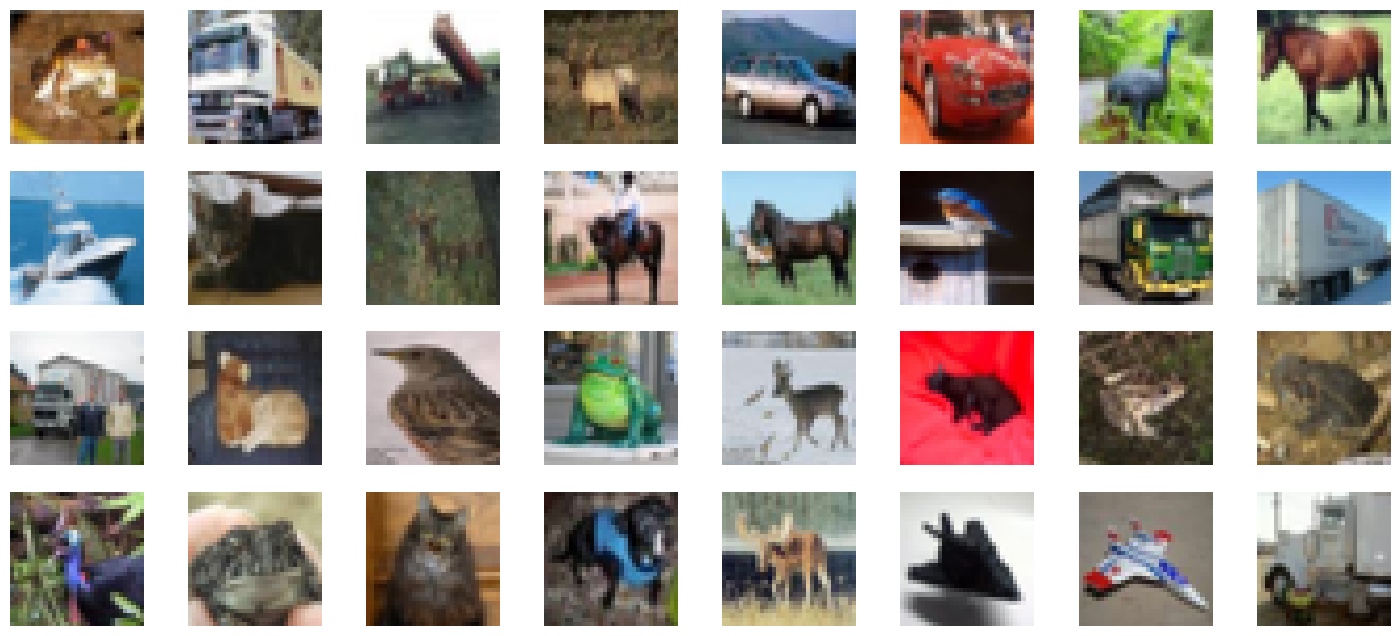

In [4]:
plt.figure(figsize=(18, 8))

num_rows = 4
num_cols = 8

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows*num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i,:,:])
    plt.axis("off")

## 2 Dataset Preprocessing

Here, we normalize the image data to the range `[0,1]`. This is very common when working with image data which helps the model train more efficiently. We also convert the integer labels to one-hot encoded labels, as discussed in previous videos.

In [5]:
# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])

# Convert labels to one-hot encoding.
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])

Original (integer) label for the first training sample:  [6]
After conversion to categorical one-hot encoded labels:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## 3 Dataset and Training Configuration Parameters

Before we describe the model implementation and training, we’re going to apply a little more structure to our training process by using the `dataclasses` module in python to create simple `DatasetConfig` and `TrainingConfig` classes to organize several data and training configuration parameters. This allows us to create data structures for configuration parameters, as shown below. The benefit of doing this is that we have a single place to go to make any desired changes.

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    NUM_CHANNELS: int = 3
    
@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 10
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001 

## 4 CNN Model Implementation in Keras

In this section, we will define a simple CNN model in Keras and train it on the CIRFAR-10 dataset. Recall from a previous notebook the following steps required to define and train a model in Keras.

1. Build/Define a network model using predefined layers in Keras
2. Compile the model with `model.compile()`
3. Train the model with `model.fit()`


### 4.1 Model Structure

Before we get into the coding details, let’s first take a look at the general structure of the model we’re proposing. Notice that the model has a similar structure to VGG-16 but has fewer layers and a much smaller input image size, and therefore far fewer trainable parameters. The model contains three convolutional blocks followed by a fully connected layer and an output layer.  For reference, we’ve included the number of channels at key points in the architecture. We have also indicated the spatial size of the activation maps at the end of each convolutional block. This is a good visual to refer back to when studying the code below.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-architecture.png' width=950 align='center'>

For convenience, we’re going to define the model in a function. Notice that the function has one optional argument: the input shape for the model. We first start by instantiating the model by calling the `sequential()` method. This allows us to build a model sequentially by adding one layer at a time. Noticed that we define three convolutional blocks and that their structure is very similar. 

### 4.2 Define the Convolutional Blocks
Let’s start with the very first convolutional layer in the first convolutional block. To define a convolutional layer in Keras, we call the `Conv2D()` function, which takes several input arguments. First, we defined the layer to have 32 filters. The kernel size for each filter is 3 (which is interpreted as 3x3). We use a padding option called `same`, which will pad the input tensor so that the output of the convolution operation has the same spatial size as the input. This is not required, but it’s commonly used. if you don’t explicitly specify this padding option, then the default behavior has no padding, and therefore, the spatial size of output from the convolutional layer will be slightly smaller than the input size. We use a `ReLU`  activation function in all the layers in the Network except for the output layer.

For the very first convolutional layer, we need to specify the shape of the input, but for all subsequent layers, this is not necessary since the shape of the input is automatically computed based on the shape of the output from previous layers, so we have two convolutional layers with 32 filters each, and then we follow that with a max pooling layer that has a window size of (2x2),  so the output shape from this first convolution block is (16x16 x32). Next, we have the second convolutional block, which is nearly identical to the first, with the exception that we have 64 filters in each convolutional layer instead of 32, and then finally, the third convolutional block is an exact copy of the second convolutional block. 

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-conv2d-layers.png' width=800 align='center'>

**Note**: The number of filters in each convolutional layer is something that you will need to experiment with. A larger number of filters allows the model to have a greater learning capacity, but this also needs to be balanced with the amount of data available to train the model. Adding too many filters (or layers) can lead to overfitting, one of the most common issues encountered when training models.

In [7]:
def cnn_model(input_shape=(32, 32, 3)):
    
    model = Sequential()
    
    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

### 4.3 Define the Classifier
Before we define the fully connected layers for the classifier, we need to first flatten the two-dimensional activation maps that are produced by the last convolutional layer (which have a spatial shape of 4x4 with 64 channels). This is accomplished by calling the `flatten()` function to create a 1-dimensional vector of length 1024. We then add a densely connected layer with 512 neurons and a fully connected output layer with ten neurons because we have ten classes in our dataset. And to avoid any confusion, we’ve also provided a detailed diagram of the fully connected layers.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-fully-connected-layers.png' width=850 align='center'>

### 4.4 Create the Model
We can now create an instance of the model by calling the function above and use the `summary()` method to display the model summary to the console.

In [8]:
# Create the model.
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

### 4.5 Compile the Model

The next step is to compile the model, where we specify the optimizer type and loss function and any additional metrics we would like recorded during training. Here we specify `RMSProp` as the optimizer type for gradient descent, and we use a cross-entropy loss function which is the standard loss function for classification problems. We specifically use `categorical_crossentropy` since our labels are one-hot encoded. Finally, we specify `accuracy` as an additional metric to record during training. The value of the loss function is always recorded by default, but if you want accuracy, you need to specify it.

In [9]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'],
             )

### 4.6 Train the Model

Since the dataset does not include a validation dataset, and since we did not previously split the training dataset to create a validation dataset, we will use the `validation_split` argument below so that 30% of the training dataset is automatically reserved for validation. This approach reserves the last 30% of the dataset for training. This is a very convenient approach, but if the training dataset has any specific ordering (say, ordered by classes), you will need to take steps to randomize the order before splitting.

In [10]:
history = model.fit(X_train,
                    y_train,
                    batch_size=TrainingConfig.BATCH_SIZE, 
                    epochs=TrainingConfig.EPOCHS, 
                    verbose=1, 
                    validation_split=.3,
                   )

Epoch 1/10
137/137 [==============================] - 125s 900ms/step - loss: 2.0931 - accuracy: 0.2314 - val_loss: 1.7612 - val_accuracy: 0.3538
Epoch 2/10
137/137 [==============================] - 96s 701ms/step - loss: 1.6588 - accuracy: 0.3966 - val_loss: 1.4500 - val_accuracy: 0.4717
Epoch 3/10
137/137 [==============================] - 103s 750ms/step - loss: 1.4049 - accuracy: 0.4930 - val_loss: 1.2591 - val_accuracy: 0.5421
Epoch 4/10
137/137 [==============================] - 96s 704ms/step - loss: 1.2317 - accuracy: 0.5599 - val_loss: 1.1179 - val_accuracy: 0.5999
Epoch 5/10
137/137 [==============================] - 97s 712ms/step - loss: 1.0913 - accuracy: 0.6144 - val_loss: 1.2004 - val_accuracy: 0.5796
Epoch 6/10
137/137 [==============================] - 100s 730ms/step - loss: 0.9738 - accuracy: 0.6563 - val_loss: 0.9605 - val_accuracy: 0.6622
Epoch 7/10
137/137 [==============================] - 99s 726ms/step - loss: 0.8673 - accuracy: 0.6956 - val_loss: 0.9448 - val

### 4.7 Plot the Training Results

The function below is a convenience function to plot training and validation losses and training and validation accuracies. It has a single required argument which is a list of metrics to plot.

In [11]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

The loss and accuracy metrics can be accessed from the `history` object returned from the fit method. We access the metrics using predefined dictionary keys, as shown below. 

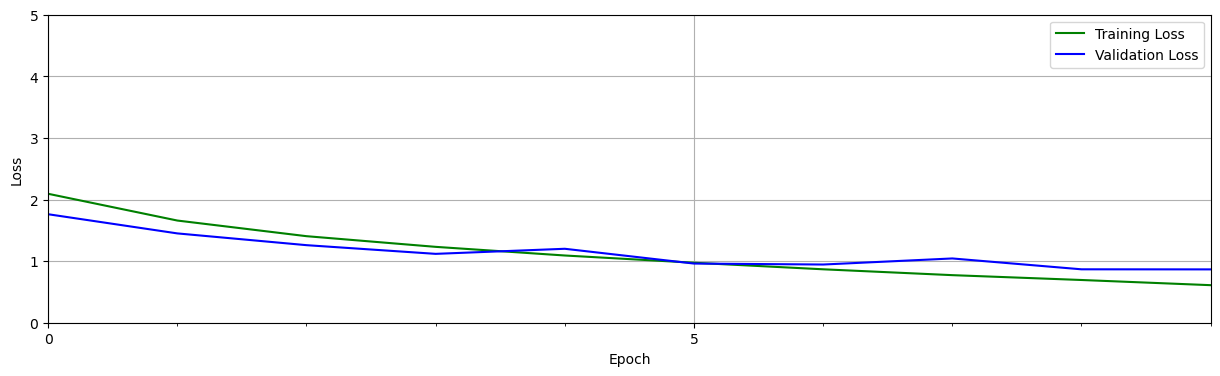

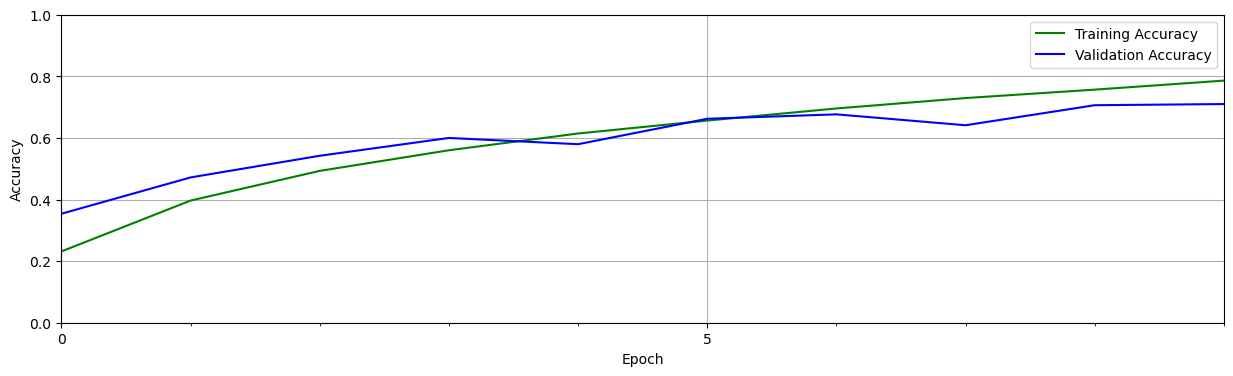

In [12]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
  
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

The results from our baseline model reveal that the model is overfitting. Notice that the validation loss increases after about ten epochs of training while the training loss continues to decline. This means that the network learns how to model the training data well but does not generalize to unseen test data well. The accuracy plot shows a similar trend where the validation accuracy levels off after about ten epochs while the training accuracy continues to approach 100% as training progresses. This is a common problem when training neural networks and can occur for a number of reasons. One reason is that the model can fit the nuances of the training dataset, especially when the training dataset is small.

## 5 Adding `Dropout` to the Model

To help mitigate this problem, we can employ one or more **regularization** strategies to help the model generalize better. Regularization techniques help to restrict the model's flexibility so that it doesn't overfit the training data. One approach is called **Dropout**, which is built into Keras. Dropout is implemented in Keras as a special layer type that randomly drops a percentage of neurons during the training process. When dropout is used in convolutional layers, it is usually used **after** the max pooling layer and has the effect of eliminating a percentage of neurons in the feature maps. When used after a fully connected layer, a percentage of neurons in the fully connected layer are dropped.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-dropout-example.png' width=650 align='center'>

In the diagram below, we add a `dropout` layer at the end of each convolutional block and also after the dense layer in the classifier. The input argument to the Dropout function is the fraction of neurons to (randomly) drop from the previous layer during the training process.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-dropout-architecture.png' width=900 align='center'>


### 5.1 Define the Model (with Dropout)

In [13]:
def cnn_model_dropout(input_shape=(32, 32, 3)):
    
    model = Sequential()
    
    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

### 5.2 Create the Model (with Dropout)

In [14]:
# Create the model.
model_dropout = cnn_model_dropout()
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

### 5.3 Compile the Model (with Dropout)

In [15]:
model_dropout.compile(optimizer='rmsprop', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'],
                     )

### 5.4 Train the Model (with Dropout)

In [16]:
history = model_dropout.fit(X_train,
                            y_train,
                            batch_size=TrainingConfig.BATCH_SIZE, 
                            epochs=TrainingConfig.EPOCHS, 
                            verbose=1, 
                            validation_split=.3,
                           )

Epoch 1/10
137/137 [==============================] - 111s 788ms/step - loss: 2.1348 - accuracy: 0.2209 - val_loss: 1.8819 - val_accuracy: 0.3212
Epoch 2/10
137/137 [==============================] - 104s 763ms/step - loss: 1.7690 - accuracy: 0.3557 - val_loss: 1.6356 - val_accuracy: 0.4035
Epoch 3/10
137/137 [==============================] - 108s 792ms/step - loss: 1.5635 - accuracy: 0.4311 - val_loss: 1.4282 - val_accuracy: 0.4746
Epoch 4/10
137/137 [==============================] - 113s 826ms/step - loss: 1.4133 - accuracy: 0.4912 - val_loss: 1.3256 - val_accuracy: 0.5107
Epoch 5/10
137/137 [==============================] - 118s 864ms/step - loss: 1.3009 - accuracy: 0.5325 - val_loss: 1.2991 - val_accuracy: 0.5418
Epoch 6/10
137/137 [==============================] - 108s 793ms/step - loss: 1.2088 - accuracy: 0.5699 - val_loss: 1.1382 - val_accuracy: 0.5865
Epoch 7/10
137/137 [==============================] - 145s 1s/step - loss: 1.1190 - accuracy: 0.6007 - val_loss: 1.1559 - va

### 5.5 Plot the Training Results

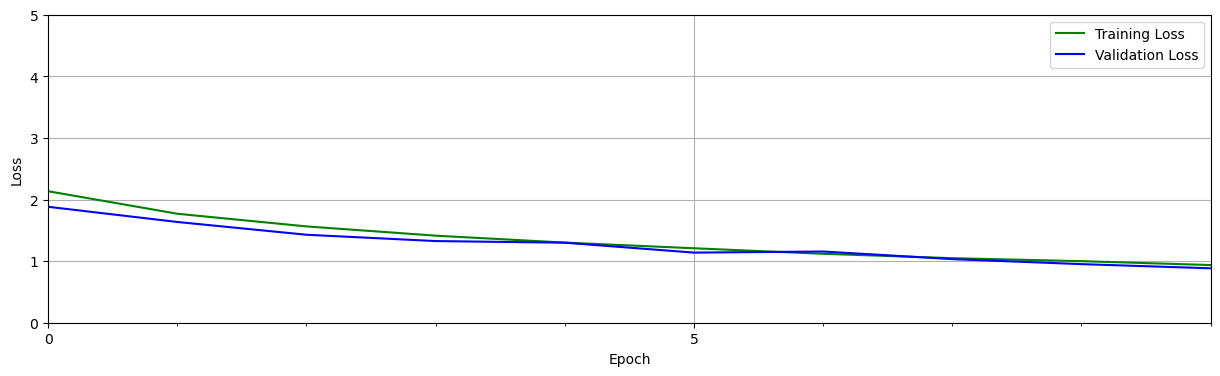

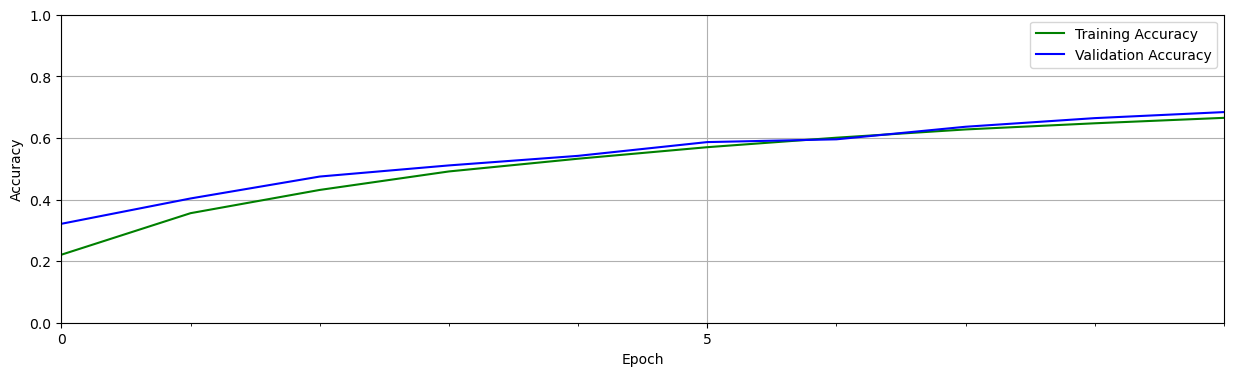

In [17]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
    
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In the plots above, the training curves align very closely with the validation curves. Also, notice that we achieve a higher validation accuracy than the baseline model that did not contain dropout. Both sets of training plots are shown below for comparison.


<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-training-plot-comparison.png' width=1000 align='center'>

## 6 Saving and Loading Models
Saving and loading models are very convenient. This enables you to develop and train a model, save it to the file system and then load it at some future time for use. This section will cover the basic operations for saving and loading models.

### 6.1 Saving Models

You can easily save a model using the `save()` method which will save the model to the file system in the 'SavedModel' format. This method creates a folder on the file system. Within this folder, the model architecture and training configuration (including the optimizer, losses, and metrics) are stored in `saved_model.pb`. The `variables/` folder contains a standard training checkpoint file that includes the weights of the model. We will delve into these details in later modules. For now, let's save the trained model, and then we'll load it in the next code cell with a different name and continue using it in the remainder of the notebook.

In [18]:
# Using the save() method, the model will be saved to the file system in the 'SavedModel' format.
model_dropout.save('model_dropout')

INFO:tensorflow:Assets written to: model_dropout\assets


INFO:tensorflow:Assets written to: model_dropout\assets


### 6.2 Saving Models

In [19]:
from tensorflow.keras import models
reloaded_model_dropout = models.load_model('model_dropout')

## 7 Model Evaluation

There are several things we can do to evaluate the trained model further. We can compute the model's accuracy on the test dataset. We can visually inspect the results on a subset of the images in a dataset and plot the confusion matrix for a dataset. Let's take a look at all three examples.

### 7.1 Evaluate the Model on the Test Dataset

Evaluating the model's accuracy on the test dataset can be computed with a single line of code as shown below. Here we use the model to call the `evaluate()` method passing in the images and the labels for the test dataset. This method returns for us the value of the loss function for the test dataset and its accuracy. So here we see that the accuracy on the text dataset is 71.7%.

In [20]:
test_loss, test_acc = reloaded_model_dropout.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

313/313 [==============================] - 9s 29ms/step - loss: 0.9035 - accuracy: 0.6810
Test accuracy: 68.100


### 7.2 Make Predictions on Sample Test Images

Here we create a convenience function that will allow us to evaluate the model on a subset of images from a dataset and display the results visually.

In [21]:
def evaluate_model(dataset, model):

    class_names = ['airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck' ]
    num_rows = 3
    num_cols = 6
    
    # Retrieve a number of images from the dataset.
    data_batch = dataset[0:num_rows*num_cols]

    # Get predictions from model.  
    predictions = model.predict(data_batch)

    plt.figure(figsize=(20, 8))
    num_matches = 0
        
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx])

        pred_idx = tf.argmax(predictions[idx]).numpy()
        truth_idx = np.nonzero(y_test[idx])
            
        title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
        title_obj = plt.title(title, fontdict={'fontsize':13})
            
        if pred_idx == truth_idx:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')
                
        acc = num_matches/(idx+1)
    print("Prediction accuracy: ", int(100*acc)/100)
    
    return

1/1 [==============================] - 0s 290ms/step
Prediction accuracy:  0.61


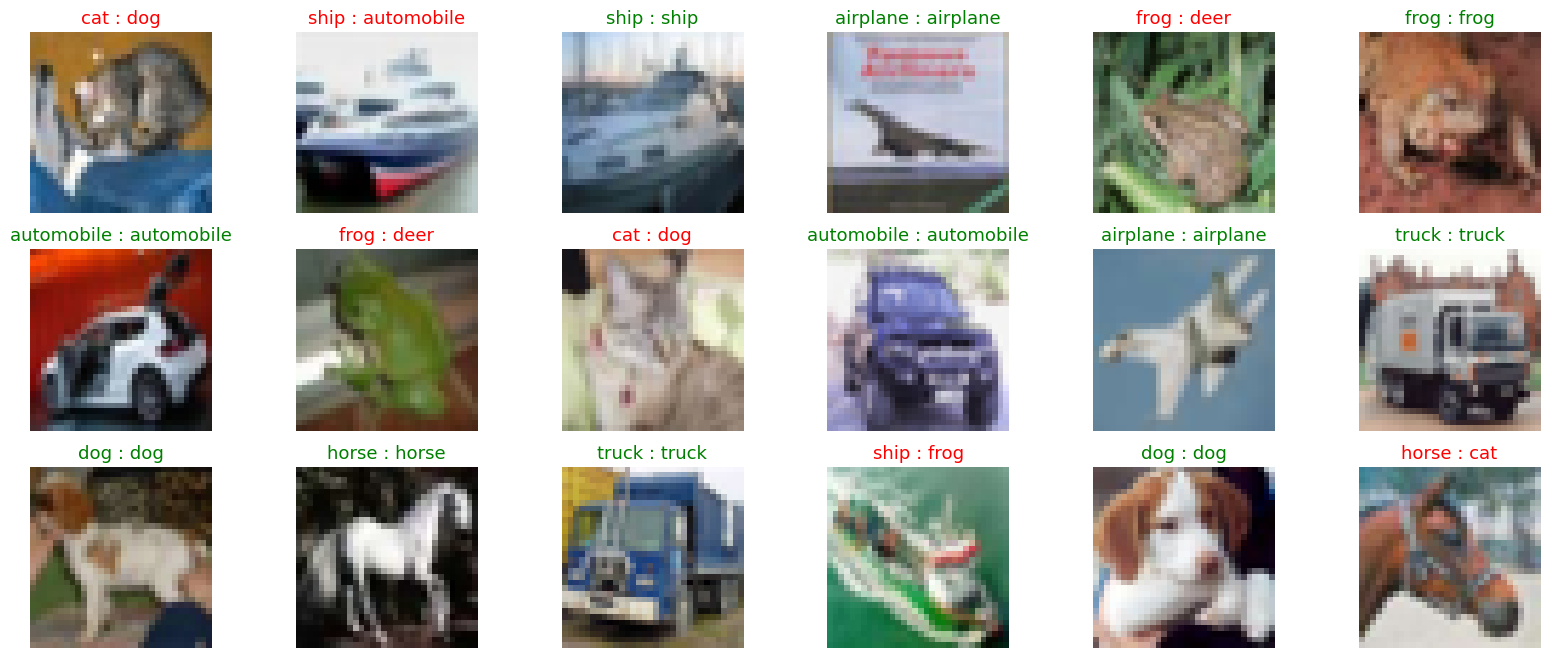

In [22]:
evaluate_model(X_test, reloaded_model_dropout)

### 7.3 Confusion Matrix
A confusion matrix is a very common metric that is used to summarize the results of a classification problem. The information is presented in the form of a table or matrix where one axis represents the ground truth labels for each class, and the other axis represents the predicted labels from the network. The entries in the table represent the number of instances from an experiment (which are sometimes represented as percentages rather than counts). Generating a confusion matrix in TensorFlow is accomplished by calling the `function tf.math.confusion_matrix()`, which takes two required arguments: the list of ground truth labels and the associated predicted labels.

In [23]:
# Generate predictions for the test dataset.
predictions = reloaded_model_dropout.predict(X_test)

# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

313/313 [==============================] - 8s 26ms/step


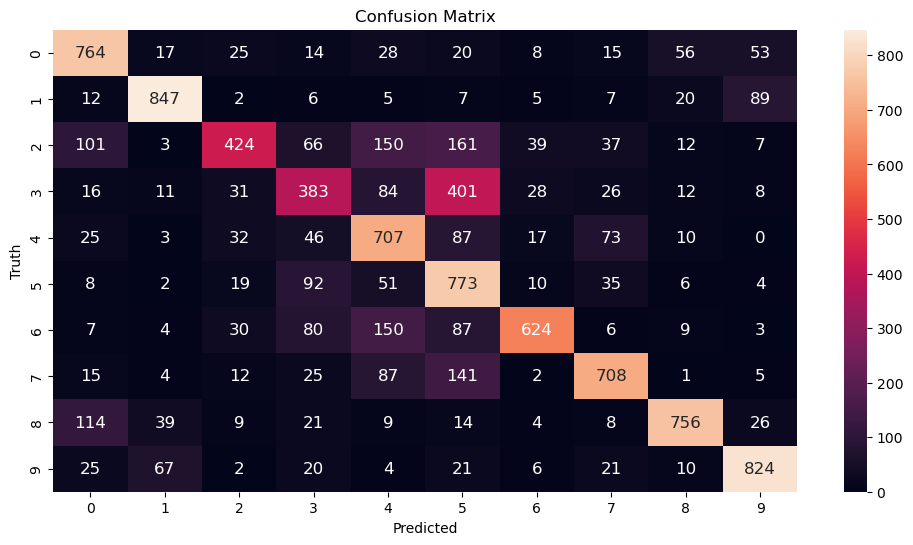

In [24]:
# Convert one-hot encoded labels to integers.
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[12, 6])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

A confusion matrix is a content-rich representation of a model’s performance at the class level. It can be very informative to better understand where the model performs well and where it may have more difficulty.  For example, a few things stand out right away. Two of the ten classes tend to be misclassified more than others: Dogs and Cat. More specifically, a large percentage of the time, the model confuses these two classes with each other. Let’s take a closer look. The ground truth label for a cat is 3, and the ground truth label for a dog is 5. Notice that when the input image is a cat (index 3), it is often most misclassified as a dog, with 176 misclassified samples. When the input image is a dog (index 5), the most misclassified examples are cats, with 117 samples. 

Also, notice that the last row, which represents trucks, is most often confused with automobiles. So all of these observations make intuitive sense, given the similarity of the classes involved.

## 8 Conclusion

In this notebook, we learned how to use TensorFlow and Keras to define and train a simple convolutional neural network. We showed that the model overfit the training data, and we learned how to use `dropout` layers to reduce the overfitting and improve the model's performance on the validation dataset. We also covered how to save and load models to and from the file system. Finally, we reviewed three techniques used to evaluate the model on the test dataset.